In [135]:
import numpy as np
import matplotlib.pyplot as plt

import PySpice
import logging

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

logger.setLevel(logging.CRITICAL)



from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from PySpice.Probe.Plot import plot
from scipy import signal as sig
import random


In [136]:
"""useful functions"""


def low_pass_filter(signal_in, cutoff_frequency, sampling_rate):
    """
    Apply a low-pass filter to a signal in the time domain.

    Parameters:
        signal_in (array-like): Input signal in the time domain.
        cutoff_frequency (float): Cutoff frequency of the low-pass filter (Hz).
        sampling_rate (float): Sampling rate of the signal (Hz).

    Returns:
        array-like: Filtered signal in the time domain.
    """
    # Normalize the cutoff frequency with respect to the Nyquist frequency
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist

    # Design a Butterworth low-pass filter
    b, a = butter(N=4, Wn=normalized_cutoff, btype='low', analog=False)

    # Apply the filter to the input signal
    filtered_signal = signal.lfilter(b, a, signal_in)

    return filtered_signal


def reconstruct_signal(times, freqs, coeffs):
    """
    Reconstruct the signal in the time domain from the Fourier spectrum.
    
    Parameters:
    - times: array of time points where the signal is to be evaluated
    - freqs: array of frequencies (usually np.arange(0, N), where N is the number of frequencies)
    - coeffs: array of complex Fourier coefficients corresponding to the frequencies
    
    Returns:
    - signal: array of signal values at the specified time points
    """
    # Number of frequency bins
    N = len(freqs)
    
    # Initialize the signal array
    signal = np.zeros_like(times, dtype=complex)
    
    # Sum the contributions of each frequency component
    for i, f in enumerate(freqs):
        # Fourier components: exp(2 * pi * f * t)
        signal += coeffs[i] * np.exp(2j * np.pi * f * times)
    
    # The real part of the signal is the time-domain signal (since it's typically real-valued)
    return np.array(np.real(signal))



def generate_complex_array(r, length):
    """
    Generates an array of complex numbers with fixed magnitude r and random phases.
    
    Parameters:
    - r: The fixed radius (magnitude) of the complex numbers
    - length: The length of the output array
    
    Returns:
    - complex_array: An array of complex numbers with fixed magnitude r and random phases
    """
    # Generate random phases between 0 and 2*pi
    phases = np.random.uniform(0, 2 * np.pi, int(length))
    
    # Generate complex numbers in polar form (r, phase)
    complex_array = r * np.exp(1j * phases)
    
    return complex_array


def singal_uniform_in_k_space(max_freq, value, times): #random phases

    freqs = np.arange(0, max_freq)  # Frequencies from 0 to 99 Hz
    coeffs = generate_complex_array(value, (max_freq) )#with fixed radius
    magnitude = np.abs(coeffs)

    # Reconstruct the signal at the given time points
    signal = reconstruct_signal(times, freqs, coeffs)
   
    return signal



In [146]:
"""Circuit Simulation"""

class Circuit_Simulator:
    
    
    # Zustände
    S1 = np.array([1, 0, 0, 1])
    S2 = np.array([0, 1, 1, 0])
    S3 = np.array([0, 0, 1, 0])
    S4 = np.array([0, 0, 0, 1])  # Ähnlich wie S3, aber andere Richtung
    S5 = np.array([0, 0, 0, 0])


    #s-space
    states = [S1,S2,S3,S4,S5]
    

    #Konstruktor
    def __init__(self,
                 Periodendauer,
                 N, #Anzahl Schaltungen in der Periode
                 data, #array [(zeitpunkt, Zustand), ()..., ()]
                 R, #Widerstand
                 L, #Induktivität
                ):
   

        self.data = data
        step_time=100@u_us
        self.T = Periodendauer
        self.N = N
        values = [[] for _ in range(4)]
        
        
        for i in range(4):
            for k in range(N):

                
                if(k>0):
                    values[i].append(((data[k][0]-1e-30)@u_ms, data[k-1][1][i]@u_V))
                    values[i].append((data[k][0]@u_ms, data[k][1][i]@u_V))
                else:
                    values[i].append((0.0@u_ms, 0@u_V))
                    values[i].append((1e-30@u_ms, data[k][1][i]@u_V))
            
                
                
        self.values = values
        self.cir = self.create_circuit(R, L)


        
        sim = self.cir.simulator(temperature = 25, nomial_temperature = 25)
        analysis = sim.transient(step_time=100@u_us, end_time= self.T@u_ms) #step time heisst nur wir wollen es mindestens so klein, die tatsächliche step time ist hier 1e-6 s
      

        self.time = np.array(analysis.time)
        self.current = np.array(analysis.L1)  
        
        
      
        new_time = np.arange(0, self.T + 1e-4, 1e-4)
        interpolation_func = interp1d(self.time, self.current, kind='linear', fill_value="extrapolate")
        new_current = interpolation_func(new_time)
        self.time = new_time
        self.current = new_current

        
        
        self.frequencies, self.fft_values, self.spectrum  = self.fourier_transform()

        

    
    '''create Circuit'''

    def create_circuit(self, Widerstand, Induktivität):
        cir = Circuit("Circuit")
        cir.V("input", "in", cir.gnd,12@u_V) 

        #add the switches
        cir.S(1, "in", "n1", "ctr1", cir.gnd, model = "SwitchModel1")
        cir.S(2, "in", "n2", "ctr2", cir.gnd, model = "SwitchModel2")
        cir.S(3, "n1", cir.gnd, "ctr3", cir.gnd, model = "SwitchModel3")
        cir.S(4, "n2", cir.gnd, "ctr4", cir.gnd, model = "SwitchModel4")

        #add diodes
        cir.model(
            'CustomDiode', 
            'D', 
            IS=1e-14,      # Saturation current
            N=1.0,         # Ideality factor
            RS=1e-2,       # Series resistance
            BV=50,         # Breakdown voltage
            IBV=1e-10,     # Reverse breakdown current
            CJO=1e-12,     # Junction capacitance
            VJ=0.7,        # Junction potential
            M=0.5          # Grading coefficient
        )
        cir.D(1, 'n1', 'in', model='CustomDiode')
        cir.D(2, 'n2', 'in', model='CustomDiode')
        cir.D(3, cir.gnd, 'n1', model='CustomDiode')
        cir.D(4, cir.gnd, 'n2', model='CustomDiode')
        
        for i in range(1,5):
            cir.model(f"SwitchModel{i}", "SW",Ron = 0.00001@u_mOhm, Roff =1e10@u_GOhm, Vt = 0.5 @u_V)
            cir.PieceWiseLinearVoltageSource(
            f"{i}__ctrl", f"ctr{i}", cir.gnd,
            values= self.values[i-1]
            )
        
        #add the coil
        cir.L(1, 'n1', 'n3', Induktivität@u_H)
        cir.R(1, 'n3', 'n2', Widerstand@u_Ohm)

        return cir
    
    

    def low_pass_filter(self, hf):
        
        dt = self.time[1] - self.time[0]
        sampling_rate =  1/dt
        nyquist = 0.5*sampling_rate

        normalized_cutoff = hf / nyquist
  
        b, a = sig.butter(N=4, Wn=normalized_cutoff, btype='low', analog=False)

        # Apply the filter to the input signal
        filtered_signal = sig.lfilter(b, a, self.current)
        
        self.current = filtered_signal

        self.frequencies, self.fft_values, self.spectrum  = self.fourier_transform()
        
        

    def fourier_transform(self):
        # Calculate Fourier Transform
        dt = self.time[1] - self.time[0]  # Time step
        N = len(self.time)           # Number of points

        freq = np.fft.fftfreq(N, d=dt)  # Frequency axis

        fft_values = np.fft.fft(self.current)  # Fourier Transform
        
    
        # Only use the positive frequencies for plotting
        freq = freq[:N // 2]
        magnitude = np.abs(fft_values[:N // 2])  # Magnitude of FFT
    
        return freq, fft_values[:N//2], magnitude


    def make_plots(self, signal = None, save = False):
        
        threshold = 0.01 * np.max(self.spectrum)  

        valid_indices = np.where(self.spectrum > threshold)[0]  
        if len(valid_indices) > 0:
            max_freq = self.frequencies[valid_indices[-1]]  # Letzte gültige Frequenz
        else:
            max_freq = 0


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        ax1.plot(self.time, self.current, label = "sim")
        if signal is not None:
            ax1.plot(self.time, signal, label = "desired signal")
            #ax1.plot(self.time, (self.current - signal)**2, label = "err^2")
        ax1.set_title("Current over Time")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Current through L1 (A)")
        ax1.legend()
        ax1.grid(True)
        
        
        ax2.plot(self.frequencies, self.spectrum, '.', label = "magnitudes simulation")
        if signal is not None:

            signal_fft = np.fft.fft(signal)
            sampling_rate = 1 / (self.time[1] - self.time[0])  # Sample rate (assuming uniform time steps)
            N = len(self.time)  # Number of points in the signal
            freqs = np.fft.fftfreq(N, d=self.time[1] - self.time[0])  # Frequency bins
            signal_fft_magnitude = np.abs(signal_fft)

            fft_mag = np.interp(self.frequencies, freqs, signal_fft_magnitude)
            ax2.plot(freqs,signal_fft_magnitude, '.', label = "magnitudes desired signal")
            
        ax2.set_title("Fourier Transform of Current Signal")
        ax2.set_xlabel("Frequency (Hz)")
        ax2.set_ylabel("Magnitude")
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax2.set_xlim(0, max_freq)
        ax2.set_ylim(0, np.max(self.spectrum) * 1.5)
        ax2.legend()

        # Adjust layout to prevent overlap between subplots
        plt.tight_layout()
        
        if(save): plt.savefig("signal_and_spectrum.png")
        
        plt.show()
    
    
    def cost_function(self, signal):
  
        anz_switches = 0
        for i in range(1, len(self.data)):

            anz_switches += np.sum(self.data[i][1] != self.data[i-1][1])
        dt = self.time[1] - self.time[0]
        anz_switches = max(1, anz_switches)
        return np.sum(dt*(self.current - signal)**2), (self.current-signal)**2 #anz_switches



In [138]:
class Data_Generators:
    
    @staticmethod
    def data_equally_spaced(period, S):
        
        '''
            period in ms,
            S is an array length N with values from 1 to 5, should always start with 5 
            S[0] is ignored
        '''
        
        N = len(S)
        step = period/N
        data = []

        for i in range(0,N):
            data.append((i*step, Circuit_Simulator.states[S[i]-1]))
         
        
        return data
    
    @staticmethod
    def randomS(N):
        
        S = [5]
        for i in range(1,N):
            S.append(random.randint(1,5))

        return S
    
    @staticmethod
    def data_equally_spaced_random(period, N):
        
        '''
        period in ms
        N = number of Switches
        '''
        
        return Data_Generators.data_equally_spaced(period, Data_Generators.randomS(N))
    
    

In [139]:
def simulation_plot(S, filter = False):
    data = Data_Generators.data_equally_spaced(period, S)

    sim = Circuit_Simulator(period@u_ms, len(data) , data,R, L)
    
    if(not highest_frequency < 0 and filter):
        sim.low_pass_filter(highest_frequency)
    sim.make_plots()

def simmulation_plot(data, filter = False):
    sim = Circuit_Simulator(period@u_ms, len(data) , data,R, L)

    if(not highest_frequency < 0 and filter):
        sim.low_pass_filter(highest_frequency)
    sim.make_plots()


def cost(S, freqs, coeffs, make_plot = False, filter = False):
    ''' S is the input array
        signal is a function - could also be an array -> update
    '''
    
    data = Data_Generators.data_equally_spaced(period, S)
    sim = Circuit_Simulator(period@u_ms, len(data) , data,R, L)
    if(not highest_frequency < 0 and filter):
        sim.low_pass_filter(highest_frequency)

    adjusted_signal = get_periodic_signal(freqs, coeffs, sim)

    if make_plot:
        sim.make_plots(adjusted_signal)
    return sim.cost_function(adjusted_signal)


def cost_data(data, signal, make_plot = False, filter = False):
    ''' S is the input array
        signal is a function - could also be an array -> update
    '''


    sim = Circuit_Simulator(period@u_ms,len(data),data,R, L)

    if(not highest_frequency < 0 and filter):
        sim.low_pass_filter(highest_frequency)

    if make_plot:
        sim.make_plots(signal)
    return sim.cost_function(signal)

In [140]:
'''SIMMULATED ANNEALING'''

def simmulated_annealing(signal, S_initial, max_iter, T_init, cooling_rate):
    
    current_state = np.copy(S_initial)
    current_cost = cost(current_state,signal)
    best_state = np.copy(current_state)
    best_cost = current_cost
    temperature = T_init
    
    for i in range(max_iter):
        
        new_state = np.copy(current_state)
        index = random.randint(0,len(new_state) -1)
        new_state[index] = random.randint(1,5)
        
        new_cost = cost(new_state, signal)
        delta_cost = new_cost - current_cost
        #print(current_cost)
        if(delta_cost < 0 or random.random() < np.exp(-delta_cost / temperature)):
            current_state = new_state
            current_cost = new_cost
            
        
        if current_cost < best_cost:
            best_state = np.copy(current_state)
            best_cost = current_cost
            
        temperature *= cooling_rate
        print(best_cost)

        
    return best_state


In [141]:
'''SIMULATION FOR EQUALLY SPACED SWITCHES - PUT YOUR PARAMETERS HERE'''
random.seed(1) #jetzt fixiert?
R = 10
L = 1
U = 12
highest_frequency = 1e2 # -1 heisst es gibt kein Tiefpassfiltern -> highest_frequency muss kleiner als 5e3 sein...
period = 100 #in ms
N = 100
S = Data_Generators.randomS(N)
print(S)
frequency = len(S)/period*1000







[5, 2, 5, 1, 3, 1, 4, 4, 4, 4, 2, 1, 4, 1, 4, 4, 5, 1, 4, 3, 2, 5, 1, 3, 1, 1, 1, 5, 1, 4, 2, 4, 1, 5, 2, 4, 4, 5, 2, 3, 2, 2, 4, 3, 1, 4, 5, 1, 2, 3, 1, 3, 5, 4, 5, 2, 3, 3, 5, 4, 5, 4, 5, 1, 4, 2, 4, 4, 2, 3, 5, 3, 1, 4, 5, 1, 2, 5, 4, 3, 4, 1, 4, 1, 3, 5, 5, 5, 4, 2, 2, 5, 2, 1, 2, 5, 5, 2, 4, 5]


In [142]:
""" SIMMULATED ANNEALING """
max_iter, T_init, cooling_rate = 50, 1, 0.8
SA_min = simmulated_annealing(np.sin, S, max_iter, T_init, cooling_rate)
cost(SA_min, np.sin, True)

print(SA_min)


TypeError: cost() missing 1 required positional argument: 'coeffs'

In [189]:
# """ PULSE-PAUSE MODULATION """
#unterteile Zeit in N Abschnitte -> wir können N mal schalten
N = 10
period = 100 # in ms 
input = [0.1, 0.2, 0.3, 0.4, 0.4, 0.1, 0.2, 0.3, 0.4, 0.4] #wie sagt wie lange Schalter an, Rest der Zeit ist er ab


def data_pulse_pause(period, input, sign):
    
    '''
        period in ms,
        input: array of length N with number between 0 and 1  (sollte dem Absolutbetrag der gewünschten Steigung entsprechen)
        sign: +1 -> positive (S1,S4), -1 -> negative (S2, S3) (sollte Vorzeichem der Gewünschten Steigung entsprechen)
    '''    
    N = len(input)
    step = period/N
    data = []
    for i in range(0,N):

        if sign[i] > 0:
            on = 1
            off = 4
        else:
            on = 2
            off = 3
            
        data.append((i*step, Circuit_Simulator.states[on-1]))
        
        if(input[i] < 1.0) :
            data.append(((i*step + (input[i])*step), Circuit_Simulator.states[off-1]))

    return data


def ppm_joel(freqs, coeffs, N):
    """ func = desired signal
        N must be smaller than period/2 -> sonst verschiebt sich das signal nach rechts"""
    #simulation für das time array
    #time = np.arange(0, period/1000 + 1e-4, 1e-4)
    
    time = np.linspace(0, period/1000, N)
    signal = reconstruct_signal(time, freqs, coeffs)
  
    signal = np.abs(max_height_signal)/np.max(np.abs(signal))*signal
    
    maximum = np.max(np.abs(signal))
    input = []
    sign = []
    n = len(time)
    step = max(1, n // (N)) # Calculate the step size, ensuring it's at least 1

    for i in range(N):
        anteil = signal[i]/maximum
        sign.append(np.sign(signal[i]))
        input.append(np.abs(anteil))

    return input, sign 

def ppm_maurice(freqs, coeffs, N):
    

    time = np.linspace(0, period/1000, N)
    signal = reconstruct_signal(time, freqs, coeffs)
    print(np.abs(max_height_signal))
    print(np.max(np.abs(signal)))
    signal = np.abs(max_height_signal)/np.max(np.abs(signal))*signal
    
  
    maximum = np.max(np.abs(signal))
    input = []
    sign = []

    for i in range(N-1):
        incline = (signal[i+1] - signal[i])/(time[i+1]-time[i])
        sign.append(np.sign(incline))
        anteil = np.min(np.array([(np.abs(incline) + R/L)/ (12 / L +  R/L), 1.0]))
        input.append(anteil)
    


    sign.append(np.sign(incline)) #bessere Lösung

    
    input.append(anteil) #bessere Lösung

    
    return input, sign


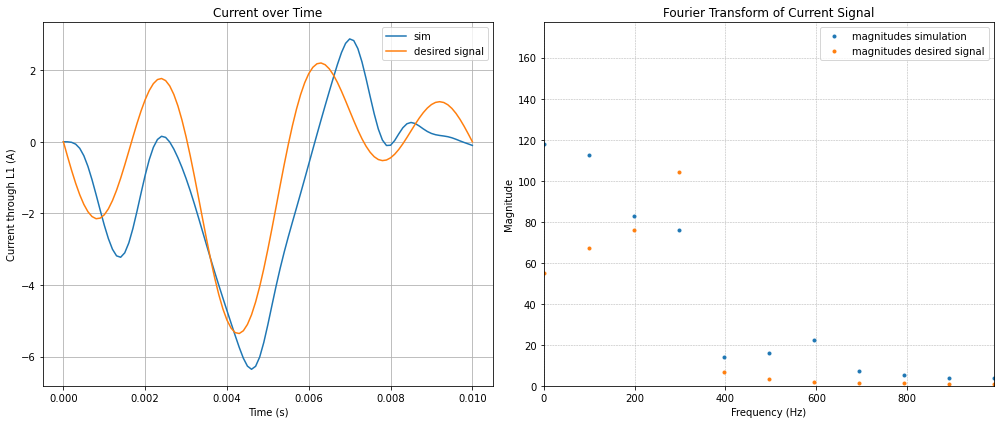

6.338550236418706
5.351668955877738


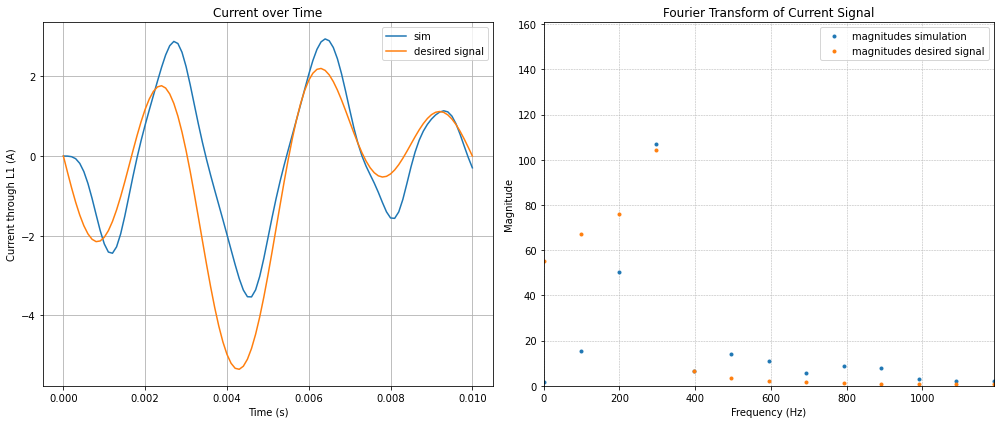

0.021730078641124313 0.014931240895198844


In [190]:
peaks = 2
freq = 1000*peaks*2*np.pi/period #freq = 2*pi*Anz_peaks/period

'''input paramteters'''
R = 0.31409132648802074 # [Ohm]
L = 0.002973796091926029 # [Henry]
U = 12
period = 10
N = 100
highest_frequency = 1e3
freqs = np.array([1,2,3,4,5,6])*50
coeffs = np.array([1j, 1j, -1j, -1j, 1j, 2j])



'''preparation'''
max_np = highest_frequency*period/(2*np.pi) #maximum number of peaks able to create
max_height_signal = period/(4*max_np)*(U/L)

time = np.arange(0, period/1000 + 1e-4, 1e-4)
signal = reconstruct_signal(time, freqs, coeffs)
#signal = np.abs(max_height_signal)/np.max(np.abs(signal))*signal

'''preparation before simulated annealing'''
input, sign = ppm_joel(freqs, coeffs*(1j), N)
data1 = data_pulse_pause(period, input, sign)
c1, dummy = cost_data(data1, signal, True, True)


input, sign = ppm_maurice(freqs, coeffs, N)
data = data_pulse_pause(period, input, sign)
c2, dummy = cost_data(data, signal, True, True)

print(c1, c2)



In [148]:
'''SIMMULATED ANNEALING'''
import math
def find_intervall(cf, data):
    '''cf ist die kostenfunktion'''
    time = np.arange(0, period/1000 + 1e-4, 1e-4)

    cf = np.array(cf)
    time = np.array(time)

    # Find the index of the maximum value in cf
    max_idx = np.argmax(cf)

    # Calculate total time span and 5% of the total time span
    total_time_span = time[-1] - time[0]
    delta = 0.05 * total_time_span

    # Determine the start and end times of the interval
    max_time = time[max_idx]
    start_time = 1000*max(max_time - delta, time[0])  # Ensure we don't go below the minimum time (in ms umrechnen)
    end_time = 1000*min(max_time + delta, time[-1])  # Ensure we don't exceed the maximum time (in mx umrechnen)

    #now find the indices for data
    a = 0
    b = len(data)-1

    
    for i in range(len(data)):
        if(data[i][0] > start_time):
            a = i
            break;
    for i in range(len(data)-1, -1, -1):

        if(data[i][0] < end_time):

            b = i
            break; 


            
    return a, b
    
def simmulated_annealing_data(signal, data_initial, max_iter, cooling_rate):
    """func: function to be approximated
        freq: freq of the function to be approximated"""
    
    current_state = np.copy(data_initial)
    current_cost, cf = cost_data(data_initial,signal)
    best_state = np.copy(current_state)
    best_cost = current_cost
    
    #finding the ideal T_init parameter, at T_init we want
    #arround 60-80% of the worse state to be accepted
    
    dc = 0
    for i in range(10):
        new_state = np.copy(current_state)
        index = random.randint(0,len(new_state) -1)
        new_state[index][1] = Circuit_Simulator.states[S[random.randint(1,4)]-1]
        new_cost, dummy = cost_data(new_state,signal)
        delta_cost = abs(new_cost - current_cost)
        dc += delta_cost
    dc /= 10
    
    
    
    temperature = - dc/math.log(0.7)
    #print("T_init: ", temperature)

    costs = np.zeros((max_iter))
    for i in range(max_iter):
        
        new_state = np.copy(current_state)
        a, b = find_intervall(cf, new_state) #suche das intervall, wo die approximation noch schlecht ist
        
        index = random.randint(a, b)
        new_state[index][1] = Circuit_Simulator.states[S[random.randint(1,4)]-1]
        
        new_cost, cf = cost_data(new_state, signal)
        delta_cost = new_cost - current_cost
        #print(current_cost)
        if(delta_cost < 0 or random.random() < np.exp(-delta_cost / temperature)):
            current_state = new_state
            current_cost = new_cost
            
        
        if current_cost < best_cost:
            best_state = np.copy(current_state)
            best_cost = current_cost
        
        temperature *= cooling_rate
        costs[i] = best_cost
        if(i%100 == 0):
            print(best_cost)


       
 
        
    return best_state, costs

array([0, 1, 1, 0])

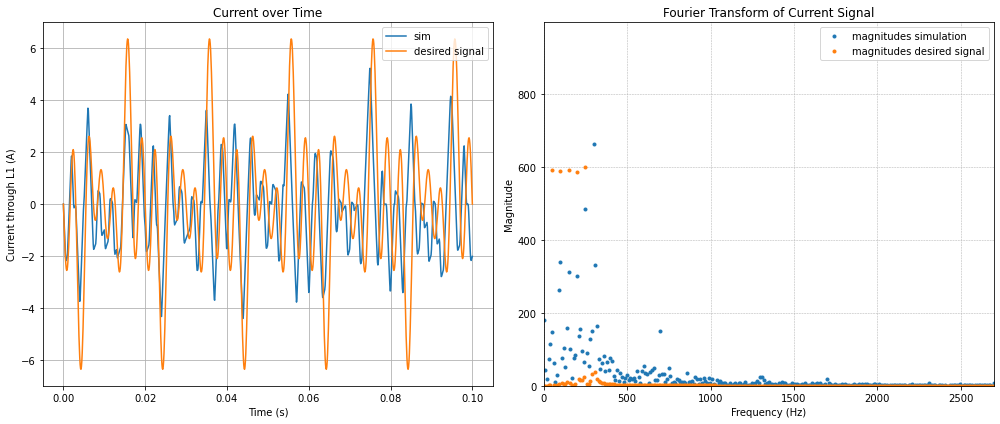

start cost 0.6059687198945294


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


0.6000609814204418
0.4964016836523642
0.48328818923829053
0.4588129547606203
0.42027834757918336
0.364138658331018
0.36118291531008345
0.360505302507551
0.36050300241858513
0.3591657731870643


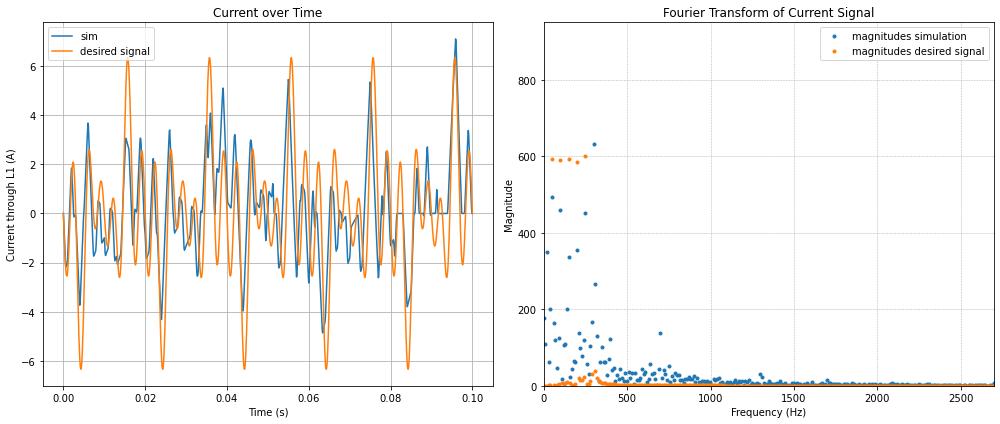

0.35890339208292343


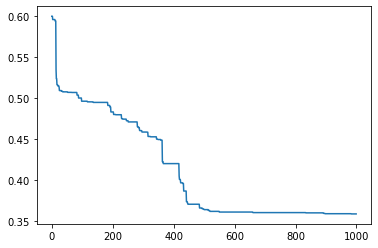

In [155]:
max_iter, cooling_rate = 1000, 0.9


"""high cooling rate = more exploration"""

c2, dummy = cost_data(data, signal, True)
print("start cost", c2)
SA_min, costs = simmulated_annealing_data(signal, data, max_iter, cooling_rate)
c_SA, dummy = cost_data(SA_min,signal, True)
plt.plot(np.arange(0, max_iter), costs)
print(c_SA)

als nächstes mit Joels version die phasenverschiebung zurücksetzten und dann das als Startwert, besser im state space suchen gehen indem wir die Funktionen anschauen

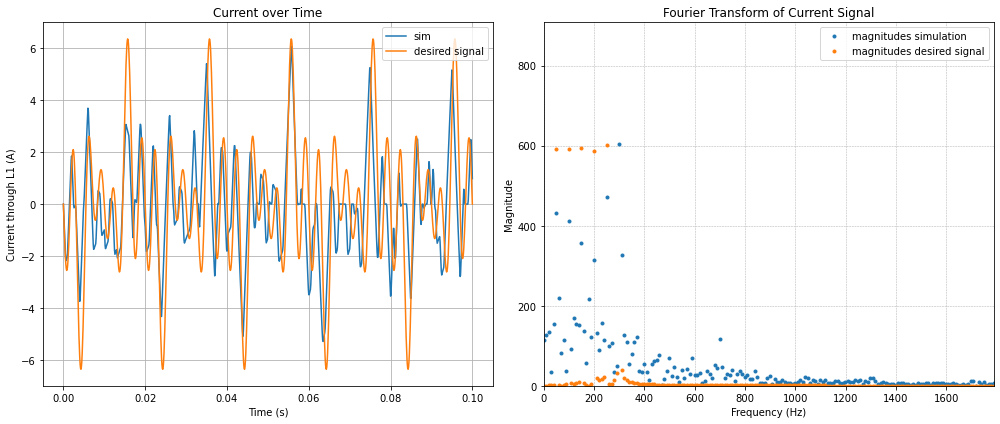

0.4118545006159845


In [154]:
c_SA, dummy = cost_data(SA_min,signal, True)
print(c_SA)

In [ ]:
print(costs[-1])

In [ ]:
    S1 = np.array([1, 0, 0, 1])
    S2 = np.array([0, 1, 1, 0])
    S3 = np.array([0, 0, 1, 0])
    S4 = np.array([0, 0, 0, 1])  # Ähnlich wie S3, aber andere Richtung
    S5 = np.array([0, 0, 0, 0])


In [ ]:
period = 1
R = 1
simulation_plot([1,4])
print(U/L*0.05)

print(U/L*0.05 - R/L*0.05)